In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[2].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:36<00:00,  2.41it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:06<00:00, 36.35it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:54<00:00,  2.12it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:06<00:00, 34.89it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   0%|          | 10/2000 [00:05<18:06,  1.83it/s]

Epoch 10/2000, Loss: 0.6599
Test Accuracy at Epoch 10: 63.95%
Test F1-score at Epoch 10: 0.6851
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.72      0.48      0.58       194
non_infringement       0.60      0.80      0.69       186

        accuracy                           0.64       380
       macro avg       0.66      0.64      0.63       380
    weighted avg       0.66      0.64      0.63       380

New best model saved with F1-score 0.6851 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.72      0.48      0.58       194
non_infringement       0.60      0.80      0.69       186

        accuracy                           0.64       380
       macro avg       0.66      0.64      0.63       380
    weighted avg       0.66      0.64      0.63       380



Training Epochs:   1%|          | 20/2000 [00:09<11:40,  2.82it/s]

Epoch 20/2000, Loss: 0.6056
Test Accuracy at Epoch 20: 49.74%
Test F1-score at Epoch 20: 0.6334
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.53      0.12      0.20       194
non_infringement       0.49      0.89      0.63       186

        accuracy                           0.50       380
       macro avg       0.51      0.51      0.42       380
    weighted avg       0.51      0.50      0.41       380



Training Epochs:   1%|▏         | 29/2000 [00:12<12:33,  2.62it/s]

Epoch 30/2000, Loss: 0.5300
Test Accuracy at Epoch 30: 72.11%
Test F1-score at Epoch 30: 0.7591
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.85      0.55      0.67       194
non_infringement       0.66      0.90      0.76       186

        accuracy                           0.72       380
       macro avg       0.75      0.72      0.71       380
    weighted avg       0.76      0.72      0.71       380



Training Epochs:   2%|▏         | 31/2000 [00:13<12:53,  2.54it/s]

New best model saved with F1-score 0.7591 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.85      0.55      0.67       194
non_infringement       0.66      0.90      0.76       186

        accuracy                           0.72       380
       macro avg       0.75      0.72      0.71       380
    weighted avg       0.76      0.72      0.71       380



Training Epochs:   2%|▏         | 40/2000 [00:16<06:44,  4.85it/s]

Epoch 40/2000, Loss: 0.4887
Test Accuracy at Epoch 40: 73.42%
Test F1-score at Epoch 40: 0.7578
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.71       194
non_infringement       0.68      0.85      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:   2%|▎         | 50/2000 [00:18<12:29,  2.60it/s]

Epoch 50/2000, Loss: 0.4313
Test Accuracy at Epoch 50: 76.32%
Test F1-score at Epoch 50: 0.7857
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.86      0.64      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380

New best model saved with F1-score 0.7857 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.86      0.64      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:   3%|▎         | 60/2000 [00:21<05:50,  5.54it/s]

Epoch 60/2000, Loss: 0.4081
Test Accuracy at Epoch 60: 79.47%
Test F1-score at Epoch 60: 0.8020
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.84      0.74      0.79       194
non_infringement       0.76      0.85      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380

New best model saved with F1-score 0.8020 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.84      0.74      0.79       194
non_infringement       0.76      0.85      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:   4%|▎         | 71/2000 [00:22<04:10,  7.70it/s]

Epoch 70/2000, Loss: 0.3526
Test Accuracy at Epoch 70: 79.47%
Test F1-score at Epoch 70: 0.8020
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.84      0.74      0.79       194
non_infringement       0.76      0.85      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:   4%|▍         | 80/2000 [00:23<05:34,  5.74it/s]

Epoch 80/2000, Loss: 0.3417
Test Accuracy at Epoch 80: 80.00%
Test F1-score at Epoch 80: 0.8257
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.95      0.64      0.77       194
non_infringement       0.72      0.97      0.83       186

        accuracy                           0.80       380
       macro avg       0.84      0.80      0.80       380
    weighted avg       0.84      0.80      0.79       380

New best model saved with F1-score 0.8257 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.95      0.64      0.77       194
non_infringement       0.72      0.97      0.83       186

        accuracy                           0.80       380
       macro avg       0.84      0.80      0.80       380
    weighted avg       0.84      0.80      0.79       380



Training Epochs:   4%|▍         | 90/2000 [00:27<15:23,  2.07it/s]

Epoch 90/2000, Loss: 0.3045
Test Accuracy at Epoch 90: 79.47%
Test F1-score at Epoch 90: 0.8219
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.84      0.79      0.79       380



Training Epochs:   5%|▌         | 100/2000 [00:31<12:57,  2.44it/s]

Epoch 100/2000, Loss: 0.3111
Test Accuracy at Epoch 100: 78.95%
Test F1-score at Epoch 100: 0.7927
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.82      0.76      0.79       194
non_infringement       0.77      0.82      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380



Training Epochs:   6%|▌         | 111/2000 [00:33<04:27,  7.05it/s]

Epoch 110/2000, Loss: 0.3070
Test Accuracy at Epoch 110: 79.74%
Test F1-score at Epoch 110: 0.8238
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.72      0.97      0.82       186

        accuracy                           0.80       380
       macro avg       0.84      0.80      0.79       380
    weighted avg       0.84      0.80      0.79       380



Training Epochs:   6%|▌         | 120/2000 [00:35<06:40,  4.69it/s]

Epoch 120/2000, Loss: 0.2886
Test Accuracy at Epoch 120: 80.53%
Test F1-score at Epoch 120: 0.8177
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.88      0.72      0.79       194
non_infringement       0.75      0.89      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:   6%|▋         | 130/2000 [00:37<07:24,  4.21it/s]

Epoch 130/2000, Loss: 0.2567
Test Accuracy at Epoch 130: 82.37%
Test F1-score at Epoch 130: 0.8401
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.85      0.82      0.82       380

New best model saved with F1-score 0.8401 at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:   7%|▋         | 140/2000 [00:39<07:17,  4.25it/s]

Epoch 140/2000, Loss: 0.2431
Test Accuracy at Epoch 140: 81.84%
Test F1-score at Epoch 140: 0.8369
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:   8%|▊         | 151/2000 [00:40<03:00, 10.26it/s]

Epoch 150/2000, Loss: 0.2552
Test Accuracy at Epoch 150: 80.26%
Test F1-score at Epoch 150: 0.8101
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.79       194
non_infringement       0.77      0.86      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:   8%|▊         | 161/2000 [00:41<03:09,  9.71it/s]

Epoch 160/2000, Loss: 0.2456
Test Accuracy at Epoch 160: 83.16%
Test F1-score at Epoch 160: 0.8483
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.86      0.83      0.83       380

New best model saved with F1-score 0.8483 at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:   9%|▊         | 171/2000 [00:42<02:55, 10.45it/s]

Epoch 170/2000, Loss: 0.2183
Test Accuracy at Epoch 170: 84.21%
Test F1-score at Epoch 170: 0.8558
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.95      0.73      0.83       194
non_infringement       0.77      0.96      0.86       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380

New best model saved with F1-score 0.8558 at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.95      0.73      0.83       194
non_infringement       0.77      0.96      0.86       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:   9%|▉         | 181/2000 [00:43<02:44, 11.07it/s]

Epoch 180/2000, Loss: 0.2130
Test Accuracy at Epoch 180: 84.21%
Test F1-score at Epoch 180: 0.8558
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.95      0.73      0.83       194
non_infringement       0.77      0.96      0.86       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  10%|▉         | 190/2000 [00:45<08:21,  3.61it/s]

Epoch 190/2000, Loss: 0.2042
Test Accuracy at Epoch 190: 83.68%
Test F1-score at Epoch 190: 0.8524
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.83       380



Training Epochs:  10%|█         | 201/2000 [00:48<05:18,  5.65it/s]

Epoch 200/2000, Loss: 0.2424
Test Accuracy at Epoch 200: 84.21%
Test F1-score at Epoch 200: 0.8551
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.94      0.74      0.83       194
non_infringement       0.78      0.95      0.86       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  11%|█         | 211/2000 [00:49<03:33,  8.40it/s]

Epoch 210/2000, Loss: 0.2021
Test Accuracy at Epoch 210: 83.42%
Test F1-score at Epoch 210: 0.8511
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.96      0.71      0.81       194
non_infringement       0.76      0.97      0.85       186

        accuracy                           0.83       380
       macro avg       0.86      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  11%|█         | 221/2000 [00:50<02:27, 12.10it/s]

Epoch 220/2000, Loss: 0.1919
Test Accuracy at Epoch 220: 83.42%
Test F1-score at Epoch 220: 0.8496
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  12%|█▏        | 231/2000 [00:51<02:11, 13.48it/s]

Epoch 230/2000, Loss: 0.2434
Test Accuracy at Epoch 230: 83.42%
Test F1-score at Epoch 230: 0.8452
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.91      0.75      0.82       194
non_infringement       0.78      0.92      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  12%|█▏        | 244/2000 [00:51<01:37, 18.08it/s]

Epoch 240/2000, Loss: 0.1927
Test Accuracy at Epoch 240: 82.89%
Test F1-score at Epoch 240: 0.8426
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.92      0.73      0.81       194
non_infringement       0.77      0.94      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  13%|█▎        | 251/2000 [00:52<01:36, 18.04it/s]

Epoch 250/2000, Loss: 0.1761
Test Accuracy at Epoch 250: 82.89%
Test F1-score at Epoch 250: 0.8426
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.92      0.73      0.81       194
non_infringement       0.77      0.94      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  13%|█▎        | 260/2000 [00:54<05:31,  5.25it/s]

Epoch 260/2000, Loss: 0.2064
Test Accuracy at Epoch 260: 70.79%
Test F1-score at Epoch 260: 0.7663
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.96      0.45      0.61       194
non_infringement       0.63      0.98      0.77       186

        accuracy                           0.71       380
       macro avg       0.79      0.71      0.69       380
    weighted avg       0.80      0.71      0.69       380



Training Epochs:  14%|█▎        | 270/2000 [00:58<11:37,  2.48it/s]

Epoch 270/2000, Loss: 0.2028
Test Accuracy at Epoch 270: 84.21%
Test F1-score at Epoch 270: 0.8551
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.94      0.74      0.83       194
non_infringement       0.78      0.95      0.86       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  14%|█▍        | 280/2000 [01:01<09:43,  2.95it/s]

Epoch 280/2000, Loss: 0.1660
Test Accuracy at Epoch 280: 83.68%
Test F1-score at Epoch 280: 0.8510
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  14%|█▍        | 290/2000 [01:06<15:44,  1.81it/s]

Epoch 290/2000, Loss: 0.1681
Test Accuracy at Epoch 290: 83.42%
Test F1-score at Epoch 290: 0.8496
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  15%|█▌        | 300/2000 [01:11<17:14,  1.64it/s]

Epoch 300/2000, Loss: 0.1556
Test Accuracy at Epoch 300: 83.68%
Test F1-score at Epoch 300: 0.8524
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.83       380



Training Epochs:  16%|█▌        | 310/2000 [01:14<11:21,  2.48it/s]

Epoch 310/2000, Loss: 0.1483
Test Accuracy at Epoch 310: 83.42%
Test F1-score at Epoch 310: 0.8496
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  16%|█▌        | 320/2000 [01:18<12:05,  2.32it/s]

Epoch 320/2000, Loss: 0.1433
Test Accuracy at Epoch 320: 82.89%
Test F1-score at Epoch 320: 0.8456
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  16%|█▋        | 330/2000 [01:23<10:12,  2.73it/s]

Epoch 330/2000, Loss: 0.1395
Test Accuracy at Epoch 330: 82.89%
Test F1-score at Epoch 330: 0.8456
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  17%|█▋        | 340/2000 [01:27<15:12,  1.82it/s]

Epoch 340/2000, Loss: 0.2992
Test Accuracy at Epoch 340: 80.53%
Test F1-score at Epoch 340: 0.8287
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.95      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  18%|█▊        | 350/2000 [01:32<09:24,  2.92it/s]

Epoch 350/2000, Loss: 0.1491
Test Accuracy at Epoch 350: 82.89%
Test F1-score at Epoch 350: 0.8418
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.92      0.73      0.81       194
non_infringement       0.77      0.93      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  18%|█▊        | 360/2000 [01:38<12:17,  2.22it/s]

Epoch 360/2000, Loss: 0.1442
Test Accuracy at Epoch 360: 75.26%
Test F1-score at Epoch 360: 0.7930
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.95      0.55      0.69       194
non_infringement       0.67      0.97      0.79       186

        accuracy                           0.75       380
       macro avg       0.81      0.76      0.74       380
    weighted avg       0.81      0.75      0.74       380



Training Epochs:  18%|█▊        | 370/2000 [01:42<11:50,  2.29it/s]

Epoch 370/2000, Loss: 0.1426
Test Accuracy at Epoch 370: 83.42%
Test F1-score at Epoch 370: 0.8504
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.86      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  19%|█▉        | 380/2000 [01:47<15:00,  1.80it/s]

Epoch 380/2000, Loss: 0.1382
Test Accuracy at Epoch 380: 82.89%
Test F1-score at Epoch 380: 0.8463
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.95      0.70      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  20%|█▉        | 390/2000 [01:49<05:25,  4.94it/s]

Epoch 390/2000, Loss: 0.1336
Test Accuracy at Epoch 390: 82.63%
Test F1-score at Epoch 390: 0.8443
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.95      0.70      0.80       194
non_infringement       0.75      0.96      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.83      0.82       380



Training Epochs:  20%|██        | 400/2000 [01:55<14:55,  1.79it/s]

Epoch 400/2000, Loss: 0.1307
Test Accuracy at Epoch 400: 82.63%
Test F1-score at Epoch 400: 0.8443
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.95      0.70      0.80       194
non_infringement       0.75      0.96      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.83      0.82       380



Training Epochs:  20%|██        | 410/2000 [02:00<14:42,  1.80it/s]

Epoch 410/2000, Loss: 0.1284
Test Accuracy at Epoch 410: 82.63%
Test F1-score at Epoch 410: 0.8443
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.95      0.70      0.80       194
non_infringement       0.75      0.96      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.83      0.82       380



Training Epochs:  21%|██        | 420/2000 [02:04<05:46,  4.56it/s]

Epoch 420/2000, Loss: 0.1262
Test Accuracy at Epoch 420: 77.37%
Test F1-score at Epoch 420: 0.8063
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.94      0.59      0.73       194
non_infringement       0.69      0.96      0.81       186

        accuracy                           0.77       380
       macro avg       0.82      0.78      0.77       380
    weighted avg       0.82      0.77      0.77       380



Training Epochs:  22%|██▏       | 431/2000 [02:05<03:32,  7.38it/s]

Epoch 430/2000, Loss: 0.1242
Test Accuracy at Epoch 430: 77.11%
Test F1-score at Epoch 430: 0.8036
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.93      0.59      0.73       194
non_infringement       0.69      0.96      0.80       186

        accuracy                           0.77       380
       macro avg       0.81      0.77      0.76       380
    weighted avg       0.82      0.77      0.76       380



Training Epochs:  22%|██▏       | 440/2000 [02:08<07:12,  3.61it/s]

Epoch 440/2000, Loss: 0.1223
Test Accuracy at Epoch 440: 77.11%
Test F1-score at Epoch 440: 0.8036
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.93      0.59      0.73       194
non_infringement       0.69      0.96      0.80       186

        accuracy                           0.77       380
       macro avg       0.81      0.77      0.76       380
    weighted avg       0.82      0.77      0.76       380



Training Epochs:  22%|██▎       | 450/2000 [02:09<03:27,  7.48it/s]

Epoch 450/2000, Loss: 0.1206
Test Accuracy at Epoch 450: 77.11%
Test F1-score at Epoch 450: 0.8036
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.93      0.59      0.73       194
non_infringement       0.69      0.96      0.80       186

        accuracy                           0.77       380
       macro avg       0.81      0.77      0.76       380
    weighted avg       0.82      0.77      0.76       380



Training Epochs:  23%|██▎       | 462/2000 [02:10<02:04, 12.37it/s]

Epoch 460/2000, Loss: 0.2457
Test Accuracy at Epoch 460: 83.42%
Test F1-score at Epoch 460: 0.8429
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.90      0.76      0.82       194
non_infringement       0.79      0.91      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.84      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  24%|██▎       | 471/2000 [02:11<01:43, 14.84it/s]

Epoch 470/2000, Loss: 0.1345
Test Accuracy at Epoch 470: 70.26%
Test F1-score at Epoch 470: 0.7611
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.94      0.45      0.61       194
non_infringement       0.63      0.97      0.76       186

        accuracy                           0.70       380
       macro avg       0.78      0.71      0.68       380
    weighted avg       0.78      0.70      0.68       380



Training Epochs:  24%|██▍       | 481/2000 [02:11<01:52, 13.53it/s]

Epoch 480/2000, Loss: 0.1225
Test Accuracy at Epoch 480: 74.47%
Test F1-score at Epoch 480: 0.7877
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.94      0.53      0.68       194
non_infringement       0.66      0.97      0.79       186

        accuracy                           0.74       380
       macro avg       0.80      0.75      0.73       380
    weighted avg       0.81      0.74      0.73       380



Training Epochs:  25%|██▍       | 493/2000 [02:12<01:37, 15.50it/s]

Epoch 490/2000, Loss: 0.1207
Test Accuracy at Epoch 490: 80.53%
Test F1-score at Epoch 490: 0.8287
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.95      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  25%|██▌       | 501/2000 [02:13<01:52, 13.32it/s]

Epoch 500/2000, Loss: 0.1195
Test Accuracy at Epoch 500: 82.37%
Test F1-score at Epoch 500: 0.8424
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.95      0.69      0.80       194
non_infringement       0.75      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  26%|██▌       | 511/2000 [02:14<02:08, 11.58it/s]

Epoch 510/2000, Loss: 0.1162
Test Accuracy at Epoch 510: 81.32%
Test F1-score at Epoch 510: 0.8305
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  26%|██▌       | 521/2000 [02:15<02:43,  9.05it/s]

Epoch 520/2000, Loss: 0.1148
Test Accuracy at Epoch 520: 75.26%
Test F1-score at Epoch 520: 0.7920
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.94      0.55      0.69       194
non_infringement       0.67      0.96      0.79       186

        accuracy                           0.75       380
       macro avg       0.81      0.76      0.74       380
    weighted avg       0.81      0.75      0.74       380



Training Epochs:  26%|██▋       | 530/2000 [02:17<06:37,  3.70it/s]

Epoch 530/2000, Loss: 0.1135
Test Accuracy at Epoch 530: 75.26%
Test F1-score at Epoch 530: 0.7920
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.94      0.55      0.69       194
non_infringement       0.67      0.96      0.79       186

        accuracy                           0.75       380
       macro avg       0.81      0.76      0.74       380
    weighted avg       0.81      0.75      0.74       380



Training Epochs:  27%|██▋       | 540/2000 [02:19<04:56,  4.92it/s]

Epoch 540/2000, Loss: 0.1122
Test Accuracy at Epoch 540: 75.26%
Test F1-score at Epoch 540: 0.7920
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.94      0.55      0.69       194
non_infringement       0.67      0.96      0.79       186

        accuracy                           0.75       380
       macro avg       0.81      0.76      0.74       380
    weighted avg       0.81      0.75      0.74       380



Training Epochs:  28%|██▊       | 552/2000 [02:21<02:19, 10.39it/s]

Epoch 550/2000, Loss: 0.1111
Test Accuracy at Epoch 550: 74.21%
Test F1-score at Epoch 550: 0.7812
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.91      0.55      0.69       194
non_infringement       0.67      0.94      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.75      0.73       380
    weighted avg       0.79      0.74      0.73       380



Training Epochs:  28%|██▊       | 562/2000 [02:21<01:35, 15.07it/s]

Epoch 560/2000, Loss: 0.1229
Test Accuracy at Epoch 560: 81.58%
Test F1-score at Epoch 560: 0.8284
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.89      0.73      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  29%|██▊       | 571/2000 [02:22<01:25, 16.79it/s]

Epoch 570/2000, Loss: 0.1112
Test Accuracy at Epoch 570: 81.84%
Test F1-score at Epoch 570: 0.8329
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  29%|██▉       | 582/2000 [02:22<01:32, 15.25it/s]

Epoch 580/2000, Loss: 0.1164
Test Accuracy at Epoch 580: 81.84%
Test F1-score at Epoch 580: 0.8337
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.76      0.93      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  30%|██▉       | 592/2000 [02:23<01:31, 15.38it/s]

Epoch 590/2000, Loss: 0.1104
Test Accuracy at Epoch 590: 79.47%
Test F1-score at Epoch 590: 0.8178
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.92      0.65      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  30%|███       | 600/2000 [02:24<01:14, 18.92it/s]

Epoch 600/2000, Loss: 0.1087
Test Accuracy at Epoch 600: 79.74%
Test F1-score at Epoch 600: 0.8197
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.92      0.66      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.80      0.79       380



Training Epochs:  31%|███       | 612/2000 [02:25<01:36, 14.38it/s]

Epoch 610/2000, Loss: 0.1068
Test Accuracy at Epoch 610: 78.68%
Test F1-score at Epoch 610: 0.8121
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  31%|███       | 620/2000 [02:25<01:30, 15.27it/s]

Epoch 620/2000, Loss: 0.1123
Test Accuracy at Epoch 620: 81.84%
Test F1-score at Epoch 620: 0.8321
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  32%|███▏      | 632/2000 [02:26<01:37, 13.97it/s]

Epoch 630/2000, Loss: 0.1263
Test Accuracy at Epoch 630: 73.16%
Test F1-score at Epoch 630: 0.7783
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  32%|███▏      | 641/2000 [02:26<01:24, 16.10it/s]

Epoch 640/2000, Loss: 0.1117
Test Accuracy at Epoch 640: 73.16%
Test F1-score at Epoch 640: 0.7783
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  33%|███▎      | 652/2000 [02:27<01:04, 20.98it/s]

Epoch 650/2000, Loss: 0.1047
Test Accuracy at Epoch 650: 78.42%
Test F1-score at Epoch 650: 0.8093
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  33%|███▎      | 661/2000 [02:27<01:07, 19.91it/s]

Epoch 660/2000, Loss: 0.1036
Test Accuracy at Epoch 660: 78.68%
Test F1-score at Epoch 660: 0.8112
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  34%|███▎      | 672/2000 [02:28<01:44, 12.67it/s]

Epoch 670/2000, Loss: 0.1256
Test Accuracy at Epoch 670: 81.58%
Test F1-score at Epoch 670: 0.8284
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.89      0.73      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  34%|███▍      | 682/2000 [02:29<01:38, 13.41it/s]

Epoch 680/2000, Loss: 0.1086
Test Accuracy at Epoch 680: 78.68%
Test F1-score at Epoch 680: 0.8121
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  34%|███▍      | 690/2000 [02:30<01:59, 11.00it/s]

Epoch 690/2000, Loss: 0.1025
Test Accuracy at Epoch 690: 78.16%
Test F1-score at Epoch 690: 0.8074
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  35%|███▌      | 703/2000 [02:32<02:34,  8.38it/s]

Epoch 700/2000, Loss: 0.1014
Test Accuracy at Epoch 700: 78.68%
Test F1-score at Epoch 700: 0.8112
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  36%|███▌      | 712/2000 [02:32<01:18, 16.40it/s]

Epoch 710/2000, Loss: 0.1204
Test Accuracy at Epoch 710: 81.58%
Test F1-score at Epoch 710: 0.8284
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.89      0.73      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  36%|███▌      | 722/2000 [02:33<01:36, 13.25it/s]

Epoch 720/2000, Loss: 0.1109
Test Accuracy at Epoch 720: 73.95%
Test F1-score at Epoch 720: 0.7834
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.94      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.74      0.73       380
    weighted avg       0.80      0.74      0.73       380



Training Epochs:  37%|███▋      | 731/2000 [02:33<01:18, 16.14it/s]

Epoch 730/2000, Loss: 0.1057
Test Accuracy at Epoch 730: 79.21%
Test F1-score at Epoch 730: 0.8132
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.77       194
non_infringement       0.73      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  37%|███▋      | 742/2000 [02:34<00:54, 23.15it/s]

Epoch 740/2000, Loss: 0.0997
Test Accuracy at Epoch 740: 78.16%
Test F1-score at Epoch 740: 0.8074
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  38%|███▊      | 751/2000 [02:34<01:17, 16.21it/s]

Epoch 750/2000, Loss: 0.1071
Test Accuracy at Epoch 750: 77.89%
Test F1-score at Epoch 750: 0.8047
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.75       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  38%|███▊      | 763/2000 [02:35<01:02, 19.80it/s]

Epoch 760/2000, Loss: 0.1022
Test Accuracy at Epoch 760: 72.89%
Test F1-score at Epoch 760: 0.7716
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.90      0.53      0.67       194
non_infringement       0.66      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  39%|███▊      | 772/2000 [02:35<00:59, 20.63it/s]

Epoch 770/2000, Loss: 0.1024
Test Accuracy at Epoch 770: 78.68%
Test F1-score at Epoch 770: 0.8094
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  39%|███▉      | 782/2000 [02:36<01:12, 16.76it/s]

Epoch 780/2000, Loss: 0.0974
Test Accuracy at Epoch 780: 78.16%
Test F1-score at Epoch 780: 0.8065
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  40%|███▉      | 791/2000 [02:36<01:10, 17.12it/s]

Epoch 790/2000, Loss: 0.1128
Test Accuracy at Epoch 790: 72.37%
Test F1-score at Epoch 790: 0.7682
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  40%|████      | 801/2000 [02:38<02:34,  7.77it/s]

Epoch 800/2000, Loss: 0.0968
Test Accuracy at Epoch 800: 78.42%
Test F1-score at Epoch 800: 0.8075
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.75       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  41%|████      | 811/2000 [02:39<01:36, 12.35it/s]

Epoch 810/2000, Loss: 0.0962
Test Accuracy at Epoch 810: 78.16%
Test F1-score at Epoch 810: 0.8056
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       194
non_infringement       0.71      0.92      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  41%|████      | 821/2000 [02:40<01:26, 13.71it/s]

Epoch 820/2000, Loss: 0.1030
Test Accuracy at Epoch 820: 79.21%
Test F1-score at Epoch 820: 0.8115
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.89      0.68      0.77       194
non_infringement       0.73      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  42%|████▏     | 832/2000 [02:40<01:05, 17.95it/s]

Epoch 830/2000, Loss: 0.1060
Test Accuracy at Epoch 830: 71.58%
Test F1-score at Epoch 830: 0.7652
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.91      0.49      0.64       194
non_infringement       0.64      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.78      0.72      0.70       380



Training Epochs:  42%|████▏     | 844/2000 [02:41<00:52, 22.08it/s]

Epoch 840/2000, Loss: 0.0985
Test Accuracy at Epoch 840: 78.68%
Test F1-score at Epoch 840: 0.8094
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  43%|████▎     | 853/2000 [02:41<00:49, 23.35it/s]

Epoch 850/2000, Loss: 0.1005
Test Accuracy at Epoch 850: 71.84%
Test F1-score at Epoch 850: 0.7638
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.88      0.52      0.65       194
non_infringement       0.65      0.93      0.76       186

        accuracy                           0.72       380
       macro avg       0.77      0.72      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  43%|████▎     | 865/2000 [02:42<00:46, 24.38it/s]

Epoch 860/2000, Loss: 0.0938
Test Accuracy at Epoch 860: 78.42%
Test F1-score at Epoch 860: 0.8084
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  44%|████▎     | 874/2000 [02:42<00:47, 23.62it/s]

Epoch 870/2000, Loss: 0.1280
Test Accuracy at Epoch 870: 72.63%
Test F1-score at Epoch 870: 0.7768
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.95      0.49      0.65       194
non_infringement       0.65      0.97      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.73      0.71       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  44%|████▍     | 880/2000 [02:43<01:02, 17.92it/s]

Epoch 880/2000, Loss: 0.0929
Test Accuracy at Epoch 880: 78.42%
Test F1-score at Epoch 880: 0.8084
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  45%|████▍     | 893/2000 [02:43<00:54, 20.41it/s]

Epoch 890/2000, Loss: 0.0964
Test Accuracy at Epoch 890: 78.68%
Test F1-score at Epoch 890: 0.8094
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  45%|████▌     | 904/2000 [02:44<00:40, 26.89it/s]

Epoch 900/2000, Loss: 0.0933
Test Accuracy at Epoch 900: 72.11%
Test F1-score at Epoch 900: 0.7655
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  46%|████▌     | 912/2000 [02:44<00:42, 25.71it/s]

Epoch 910/2000, Loss: 0.0983
Test Accuracy at Epoch 910: 72.11%
Test F1-score at Epoch 910: 0.7665
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  46%|████▌     | 924/2000 [02:44<00:41, 26.12it/s]

Epoch 920/2000, Loss: 0.0920
Test Accuracy at Epoch 920: 72.11%
Test F1-score at Epoch 920: 0.7655
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  47%|████▋     | 932/2000 [02:45<00:35, 29.71it/s]

Epoch 930/2000, Loss: 0.1090
Test Accuracy at Epoch 930: 71.05%
Test F1-score at Epoch 930: 0.7609
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.90      0.49      0.63       194
non_infringement       0.64      0.94      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.77      0.71      0.70       380



Training Epochs:  47%|████▋     | 944/2000 [02:45<00:34, 30.94it/s]

Epoch 940/2000, Loss: 0.0921
Test Accuracy at Epoch 940: 78.42%
Test F1-score at Epoch 940: 0.8075
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.75       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  48%|████▊     | 952/2000 [02:45<00:33, 31.39it/s]

Epoch 950/2000, Loss: 0.0934
Test Accuracy at Epoch 950: 72.37%
Test F1-score at Epoch 950: 0.7682
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  48%|████▊     | 964/2000 [02:46<00:38, 26.66it/s]

Epoch 960/2000, Loss: 0.0896
Test Accuracy at Epoch 960: 77.89%
Test F1-score at Epoch 960: 0.8019
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.89      0.65      0.75       194
non_infringement       0.71      0.91      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  49%|████▉     | 975/2000 [02:46<00:37, 27.53it/s]

Epoch 970/2000, Loss: 0.0904
Test Accuracy at Epoch 970: 78.42%
Test F1-score at Epoch 970: 0.8075
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.75       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  49%|████▉     | 983/2000 [02:46<00:36, 28.11it/s]

Epoch 980/2000, Loss: 0.0879
Test Accuracy at Epoch 980: 78.16%
Test F1-score at Epoch 980: 0.8056
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       194
non_infringement       0.71      0.92      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  50%|████▉     | 991/2000 [02:47<00:37, 27.02it/s]

Epoch 990/2000, Loss: 0.0927
Test Accuracy at Epoch 990: 78.16%
Test F1-score at Epoch 990: 0.8038
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.89      0.65      0.75       194
non_infringement       0.72      0.91      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  50%|█████     | 1005/2000 [02:47<00:27, 36.24it/s]

Epoch 1000/2000, Loss: 0.0947
Test Accuracy at Epoch 1000: 73.42%
Test F1-score at Epoch 1000: 0.7819
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.95      0.51      0.66       194
non_infringement       0.65      0.97      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.81      0.73      0.72       380



Training Epochs:  51%|█████     | 1018/2000 [02:47<00:26, 37.76it/s]

Epoch 1010/2000, Loss: 0.0869
Test Accuracy at Epoch 1010: 78.16%
Test F1-score at Epoch 1010: 0.8047
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.89      0.65      0.75       194
non_infringement       0.72      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  51%|█████▏    | 1027/2000 [02:48<00:25, 37.69it/s]

Epoch 1020/2000, Loss: 0.0943
Test Accuracy at Epoch 1020: 78.16%
Test F1-score at Epoch 1020: 0.8038
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.89      0.65      0.75       194
non_infringement       0.72      0.91      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  52%|█████▏    | 1036/2000 [02:48<00:26, 36.69it/s]

Epoch 1030/2000, Loss: 0.0913
Test Accuracy at Epoch 1030: 73.68%
Test F1-score at Epoch 1030: 0.7835
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.95      0.51      0.66       194
non_infringement       0.66      0.97      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.81      0.74      0.72       380



Training Epochs:  52%|█████▏    | 1047/2000 [02:48<00:22, 42.09it/s]

Epoch 1040/2000, Loss: 0.0859
Test Accuracy at Epoch 1040: 77.89%
Test F1-score at Epoch 1040: 0.8028
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.89      0.64      0.75       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  53%|█████▎    | 1052/2000 [02:48<00:24, 38.47it/s]

Epoch 1050/2000, Loss: 0.0956
Test Accuracy at Epoch 1050: 78.42%
Test F1-score at Epoch 1050: 0.8048
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.88      0.66      0.76       194
non_infringement       0.72      0.91      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  53%|█████▎    | 1068/2000 [02:49<00:20, 45.99it/s]

Epoch 1060/2000, Loss: 0.0880
Test Accuracy at Epoch 1060: 72.89%
Test F1-score at Epoch 1060: 0.7756
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  54%|█████▍    | 1079/2000 [02:49<00:21, 43.17it/s]

Epoch 1070/2000, Loss: 0.0867
Test Accuracy at Epoch 1070: 78.42%
Test F1-score at Epoch 1070: 0.8111
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  54%|█████▍    | 1084/2000 [02:49<00:21, 43.59it/s]

Epoch 1080/2000, Loss: 0.0922
Test Accuracy at Epoch 1080: 78.68%
Test F1-score at Epoch 1080: 0.8076
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.89      0.66      0.76       194
non_infringement       0.72      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  55%|█████▍    | 1094/2000 [02:49<00:22, 40.44it/s]

Epoch 1090/2000, Loss: 0.0872
Test Accuracy at Epoch 1090: 73.16%
Test F1-score at Epoch 1090: 0.7783
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  55%|█████▌    | 1105/2000 [02:50<00:24, 37.20it/s]

Epoch 1100/2000, Loss: 0.0841
Test Accuracy at Epoch 1100: 78.95%
Test F1-score at Epoch 1100: 0.8148
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  56%|█████▌    | 1115/2000 [02:50<00:21, 40.99it/s]

Epoch 1110/2000, Loss: 0.0950
Test Accuracy at Epoch 1110: 78.68%
Test F1-score at Epoch 1110: 0.8076
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.89      0.66      0.76       194
non_infringement       0.72      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  56%|█████▌    | 1124/2000 [02:50<00:24, 35.90it/s]

Epoch 1120/2000, Loss: 0.0900
Test Accuracy at Epoch 1120: 72.11%
Test F1-score at Epoch 1120: 0.7716
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  57%|█████▋    | 1136/2000 [02:51<00:27, 31.12it/s]

Epoch 1130/2000, Loss: 0.0834
Test Accuracy at Epoch 1130: 78.68%
Test F1-score at Epoch 1130: 0.8129
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  57%|█████▋    | 1144/2000 [02:51<00:28, 30.03it/s]

Epoch 1140/2000, Loss: 0.0944
Test Accuracy at Epoch 1140: 79.21%
Test F1-score at Epoch 1140: 0.8115
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.89      0.68      0.77       194
non_infringement       0.73      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  58%|█████▊    | 1152/2000 [02:51<00:31, 26.75it/s]

Epoch 1150/2000, Loss: 0.0940
Test Accuracy at Epoch 1150: 72.63%
Test F1-score at Epoch 1150: 0.7759
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.94      0.49      0.65       194
non_infringement       0.65      0.97      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  58%|█████▊    | 1163/2000 [02:52<00:37, 22.39it/s]

Epoch 1160/2000, Loss: 0.0853
Test Accuracy at Epoch 1160: 78.95%
Test F1-score at Epoch 1160: 0.8148
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  59%|█████▉    | 1176/2000 [02:52<00:34, 23.99it/s]

Epoch 1170/2000, Loss: 0.0850
Test Accuracy at Epoch 1170: 78.68%
Test F1-score at Epoch 1170: 0.8155
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  59%|█████▉    | 1182/2000 [02:52<00:35, 23.09it/s]

Epoch 1180/2000, Loss: 0.0823
Test Accuracy at Epoch 1180: 78.68%
Test F1-score at Epoch 1180: 0.8129
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  60%|█████▉    | 1192/2000 [02:53<00:33, 23.91it/s]

Epoch 1190/2000, Loss: 0.1041
Test Accuracy at Epoch 1190: 79.74%
Test F1-score at Epoch 1190: 0.8188
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  60%|██████    | 1202/2000 [02:53<00:34, 23.25it/s]

Epoch 1200/2000, Loss: 0.0823
Test Accuracy at Epoch 1200: 78.68%
Test F1-score at Epoch 1200: 0.8129
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  61%|██████    | 1213/2000 [02:54<00:31, 24.89it/s]

Epoch 1210/2000, Loss: 0.0838
Test Accuracy at Epoch 1210: 73.42%
Test F1-score at Epoch 1210: 0.7800
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  61%|██████    | 1224/2000 [02:54<00:28, 26.82it/s]

Epoch 1220/2000, Loss: 0.0821
Test Accuracy at Epoch 1220: 78.68%
Test F1-score at Epoch 1220: 0.8129
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  62%|██████▏   | 1235/2000 [02:55<00:27, 27.86it/s]

Epoch 1230/2000, Loss: 0.0854
Test Accuracy at Epoch 1230: 78.95%
Test F1-score at Epoch 1230: 0.8140
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  62%|██████▏   | 1238/2000 [02:55<00:45, 16.78it/s]

Epoch 1240/2000, Loss: 0.0813
Test Accuracy at Epoch 1240: 78.95%
Test F1-score at Epoch 1240: 0.8157
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  63%|██████▎   | 1252/2000 [02:56<00:58, 12.81it/s]

Epoch 1250/2000, Loss: 0.0985
Test Accuracy at Epoch 1250: 80.53%
Test F1-score at Epoch 1250: 0.8255
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  63%|██████▎   | 1261/2000 [02:57<00:51, 14.29it/s]

Epoch 1260/2000, Loss: 0.0874
Test Accuracy at Epoch 1260: 78.42%
Test F1-score at Epoch 1260: 0.8128
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  64%|██████▍   | 1275/2000 [02:58<00:35, 20.21it/s]

Epoch 1270/2000, Loss: 0.0822
Test Accuracy at Epoch 1270: 73.68%
Test F1-score at Epoch 1270: 0.7826
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.94      0.52      0.67       194
non_infringement       0.66      0.97      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  64%|██████▍   | 1283/2000 [02:58<00:49, 14.49it/s]

Epoch 1280/2000, Loss: 0.0824
Test Accuracy at Epoch 1280: 78.68%
Test F1-score at Epoch 1280: 0.8129
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  65%|██████▍   | 1292/2000 [02:59<00:41, 17.10it/s]

Epoch 1290/2000, Loss: 0.0805
Test Accuracy at Epoch 1290: 78.95%
Test F1-score at Epoch 1290: 0.8165
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  65%|██████▌   | 1304/2000 [02:59<00:33, 21.07it/s]

Epoch 1300/2000, Loss: 0.0891
Test Accuracy at Epoch 1300: 72.37%
Test F1-score at Epoch 1300: 0.7742
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.94      0.49      0.64       194
non_infringement       0.65      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.80      0.72      0.71       380



Training Epochs:  66%|██████▌   | 1310/2000 [03:00<00:35, 19.48it/s]

Epoch 1310/2000, Loss: 0.0860
Test Accuracy at Epoch 1310: 78.95%
Test F1-score at Epoch 1310: 0.8140
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  66%|██████▌   | 1321/2000 [03:01<00:58, 11.61it/s]

Epoch 1320/2000, Loss: 0.0824
Test Accuracy at Epoch 1320: 73.95%
Test F1-score at Epoch 1320: 0.7843
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.94      0.52      0.67       194
non_infringement       0.66      0.97      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.74      0.73       380
    weighted avg       0.80      0.74      0.73       380



Training Epochs:  66%|██████▋   | 1330/2000 [03:04<03:34,  3.13it/s]

Epoch 1330/2000, Loss: 0.0801
Test Accuracy at Epoch 1330: 78.95%
Test F1-score at Epoch 1330: 0.8165
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  67%|██████▋   | 1340/2000 [03:06<02:11,  5.00it/s]

Epoch 1340/2000, Loss: 0.0882
Test Accuracy at Epoch 1340: 78.95%
Test F1-score at Epoch 1340: 0.8140
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  68%|██████▊   | 1350/2000 [03:11<05:59,  1.81it/s]

Epoch 1350/2000, Loss: 0.0830
Test Accuracy at Epoch 1350: 73.68%
Test F1-score at Epoch 1350: 0.7826
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.94      0.52      0.67       194
non_infringement       0.66      0.97      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  68%|██████▊   | 1360/2000 [03:16<05:53,  1.81it/s]

Epoch 1360/2000, Loss: 0.0796
Test Accuracy at Epoch 1360: 78.95%
Test F1-score at Epoch 1360: 0.8165
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  68%|██████▊   | 1370/2000 [03:20<04:30,  2.33it/s]

Epoch 1370/2000, Loss: 0.0870
Test Accuracy at Epoch 1370: 78.95%
Test F1-score at Epoch 1370: 0.8140
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  69%|██████▉   | 1380/2000 [03:23<03:17,  3.14it/s]

Epoch 1380/2000, Loss: 0.0869
Test Accuracy at Epoch 1380: 72.63%
Test F1-score at Epoch 1380: 0.7759
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.94      0.49      0.65       194
non_infringement       0.65      0.97      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  70%|██████▉   | 1390/2000 [03:25<02:28,  4.11it/s]

Epoch 1390/2000, Loss: 0.0836
Test Accuracy at Epoch 1390: 78.68%
Test F1-score at Epoch 1390: 0.8129
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  70%|██████▉   | 1399/2000 [03:27<01:38,  6.13it/s]

Epoch 1400/2000, Loss: 0.0798
Test Accuracy at Epoch 1400: 78.95%
Test F1-score at Epoch 1400: 0.8174
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  70%|███████   | 1410/2000 [03:31<04:41,  2.10it/s]

Epoch 1410/2000, Loss: 0.0820
Test Accuracy at Epoch 1410: 78.95%
Test F1-score at Epoch 1410: 0.8174
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  71%|███████   | 1420/2000 [03:37<05:50,  1.65it/s]

Epoch 1420/2000, Loss: 0.0797
Test Accuracy at Epoch 1420: 78.95%
Test F1-score at Epoch 1420: 0.8157
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  72%|███████▏  | 1433/2000 [03:39<01:03,  8.89it/s]

Epoch 1430/2000, Loss: 0.0804
Test Accuracy at Epoch 1430: 78.95%
Test F1-score at Epoch 1430: 0.8157
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  72%|███████▏  | 1439/2000 [03:41<01:37,  5.78it/s]

Epoch 1440/2000, Loss: 0.0801
Test Accuracy at Epoch 1440: 78.68%
Test F1-score at Epoch 1440: 0.8146
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  72%|███████▎  | 1450/2000 [03:41<00:37, 14.48it/s]

Epoch 1450/2000, Loss: 0.0830
Test Accuracy at Epoch 1450: 78.68%
Test F1-score at Epoch 1450: 0.8129
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  73%|███████▎  | 1460/2000 [03:46<03:03,  2.95it/s]

Epoch 1460/2000, Loss: 0.0783
Test Accuracy at Epoch 1460: 78.68%
Test F1-score at Epoch 1460: 0.8146
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  74%|███████▎  | 1471/2000 [03:47<01:11,  7.38it/s]

Epoch 1470/2000, Loss: 0.0907
Test Accuracy at Epoch 1470: 73.68%
Test F1-score at Epoch 1470: 0.7826
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.94      0.52      0.67       194
non_infringement       0.66      0.97      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  74%|███████▍  | 1479/2000 [03:47<00:36, 14.37it/s]

Epoch 1480/2000, Loss: 0.0832
Test Accuracy at Epoch 1480: 78.68%
Test F1-score at Epoch 1480: 0.8129
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  74%|███████▍  | 1490/2000 [03:53<04:22,  1.95it/s]

Epoch 1490/2000, Loss: 0.0814
Test Accuracy at Epoch 1490: 78.42%
Test F1-score at Epoch 1490: 0.8128
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  75%|███████▌  | 1502/2000 [03:56<01:08,  7.32it/s]

Epoch 1500/2000, Loss: 0.0780
Test Accuracy at Epoch 1500: 78.95%
Test F1-score at Epoch 1500: 0.8165
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  76%|███████▌  | 1510/2000 [03:56<00:43, 11.20it/s]

Epoch 1510/2000, Loss: 0.0854
Test Accuracy at Epoch 1510: 78.95%
Test F1-score at Epoch 1510: 0.8131
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  76%|███████▌  | 1522/2000 [03:58<00:51,  9.31it/s]

Epoch 1520/2000, Loss: 0.0811
Test Accuracy at Epoch 1520: 73.42%
Test F1-score at Epoch 1520: 0.7800
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  77%|███████▋  | 1531/2000 [03:59<00:51,  9.08it/s]

Epoch 1530/2000, Loss: 0.0779
Test Accuracy at Epoch 1530: 78.95%
Test F1-score at Epoch 1530: 0.8165
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  77%|███████▋  | 1540/2000 [04:01<01:25,  5.36it/s]

Epoch 1540/2000, Loss: 0.0850
Test Accuracy at Epoch 1540: 78.42%
Test F1-score at Epoch 1540: 0.8102
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  78%|███████▊  | 1550/2000 [04:03<01:31,  4.93it/s]

Epoch 1550/2000, Loss: 0.0803
Test Accuracy at Epoch 1550: 73.42%
Test F1-score at Epoch 1550: 0.7800
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  78%|███████▊  | 1560/2000 [04:07<03:33,  2.06it/s]

Epoch 1560/2000, Loss: 0.0778
Test Accuracy at Epoch 1560: 78.95%
Test F1-score at Epoch 1560: 0.8165
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  78%|███████▊  | 1570/2000 [04:11<01:40,  4.26it/s]

Epoch 1570/2000, Loss: 0.0828
Test Accuracy at Epoch 1570: 78.42%
Test F1-score at Epoch 1570: 0.8102
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  79%|███████▉  | 1582/2000 [04:13<00:52,  8.03it/s]

Epoch 1580/2000, Loss: 0.0794
Test Accuracy at Epoch 1580: 72.89%
Test F1-score at Epoch 1580: 0.7766
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  80%|███████▉  | 1592/2000 [04:14<00:37, 10.89it/s]

Epoch 1590/2000, Loss: 0.0773
Test Accuracy at Epoch 1590: 78.95%
Test F1-score at Epoch 1590: 0.8165
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  80%|████████  | 1601/2000 [04:14<00:29, 13.67it/s]

Epoch 1600/2000, Loss: 0.0836
Test Accuracy at Epoch 1600: 78.42%
Test F1-score at Epoch 1600: 0.8102
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  81%|████████  | 1612/2000 [04:15<00:25, 14.98it/s]

Epoch 1610/2000, Loss: 0.0788
Test Accuracy at Epoch 1610: 78.68%
Test F1-score at Epoch 1610: 0.8155
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  81%|████████  | 1622/2000 [04:16<00:26, 14.15it/s]

Epoch 1620/2000, Loss: 0.0784
Test Accuracy at Epoch 1620: 78.95%
Test F1-score at Epoch 1620: 0.8165
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  82%|████████▏ | 1630/2000 [04:16<00:26, 13.78it/s]

Epoch 1630/2000, Loss: 0.0793
Test Accuracy at Epoch 1630: 78.95%
Test F1-score at Epoch 1630: 0.8157
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  82%|████████▏ | 1641/2000 [04:18<00:40,  8.87it/s]

Epoch 1640/2000, Loss: 0.0772
Test Accuracy at Epoch 1640: 78.95%
Test F1-score at Epoch 1640: 0.8165
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  83%|████████▎ | 1651/2000 [04:19<00:28, 12.14it/s]

Epoch 1650/2000, Loss: 0.0784
Test Accuracy at Epoch 1650: 78.68%
Test F1-score at Epoch 1650: 0.8146
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  83%|████████▎ | 1662/2000 [04:20<00:22, 15.18it/s]

Epoch 1660/2000, Loss: 0.0803
Test Accuracy at Epoch 1660: 78.68%
Test F1-score at Epoch 1660: 0.8129
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  84%|████████▎ | 1670/2000 [04:21<01:16,  4.31it/s]

Epoch 1670/2000, Loss: 0.0771
Test Accuracy at Epoch 1670: 78.68%
Test F1-score at Epoch 1670: 0.8146
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  84%|████████▍ | 1681/2000 [04:27<01:37,  3.28it/s]

Epoch 1680/2000, Loss: 0.0842
Test Accuracy at Epoch 1680: 72.63%
Test F1-score at Epoch 1680: 0.7749
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  84%|████████▍ | 1690/2000 [04:29<01:32,  3.35it/s]

Epoch 1690/2000, Loss: 0.0787
Test Accuracy at Epoch 1690: 78.95%
Test F1-score at Epoch 1690: 0.8157
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  85%|████████▌ | 1702/2000 [04:31<00:35,  8.50it/s]

Epoch 1700/2000, Loss: 0.0771
Test Accuracy at Epoch 1700: 78.95%
Test F1-score at Epoch 1700: 0.8165
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  86%|████████▌ | 1710/2000 [04:32<00:57,  5.06it/s]

Epoch 1710/2000, Loss: 0.0823
Test Accuracy at Epoch 1710: 72.89%
Test F1-score at Epoch 1710: 0.7766
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  86%|████████▌ | 1721/2000 [04:34<00:35,  7.97it/s]

Epoch 1720/2000, Loss: 0.0771
Test Accuracy at Epoch 1720: 78.95%
Test F1-score at Epoch 1720: 0.8157
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  86%|████████▋ | 1730/2000 [04:37<01:39,  2.72it/s]

Epoch 1730/2000, Loss: 0.0795
Test Accuracy at Epoch 1730: 78.95%
Test F1-score at Epoch 1730: 0.8157
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  87%|████████▋ | 1740/2000 [04:41<01:35,  2.72it/s]

Epoch 1740/2000, Loss: 0.0790
Test Accuracy at Epoch 1740: 72.89%
Test F1-score at Epoch 1740: 0.7766
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  88%|████████▊ | 1750/2000 [04:42<00:32,  7.63it/s]

Epoch 1750/2000, Loss: 0.0769
Test Accuracy at Epoch 1750: 78.95%
Test F1-score at Epoch 1750: 0.8165
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  88%|████████▊ | 1760/2000 [04:43<00:32,  7.49it/s]

Epoch 1760/2000, Loss: 0.0812
Test Accuracy at Epoch 1760: 78.68%
Test F1-score at Epoch 1760: 0.8121
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  88%|████████▊ | 1770/2000 [04:47<01:45,  2.18it/s]

Epoch 1770/2000, Loss: 0.0770
Test Accuracy at Epoch 1770: 77.89%
Test F1-score at Epoch 1770: 0.8091
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.77       380
    weighted avg       0.82      0.78      0.77       380



Training Epochs:  89%|████████▉ | 1780/2000 [04:50<00:35,  6.24it/s]

Epoch 1780/2000, Loss: 0.0798
Test Accuracy at Epoch 1780: 78.42%
Test F1-score at Epoch 1780: 0.8128
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  90%|████████▉ | 1791/2000 [04:51<00:22,  9.17it/s]

Epoch 1790/2000, Loss: 0.0807
Test Accuracy at Epoch 1790: 78.68%
Test F1-score at Epoch 1790: 0.8121
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  90%|█████████ | 1801/2000 [04:52<00:22,  8.87it/s]

Epoch 1800/2000, Loss: 0.0764
Test Accuracy at Epoch 1800: 78.68%
Test F1-score at Epoch 1800: 0.8146
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  90%|█████████ | 1810/2000 [04:53<00:19,  9.73it/s]

Epoch 1810/2000, Loss: 0.0833
Test Accuracy at Epoch 1810: 72.89%
Test F1-score at Epoch 1810: 0.7766
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  91%|█████████ | 1820/2000 [04:56<01:10,  2.55it/s]

Epoch 1820/2000, Loss: 0.0778
Test Accuracy at Epoch 1820: 78.95%
Test F1-score at Epoch 1820: 0.8157
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  92%|█████████▏| 1830/2000 [05:01<01:20,  2.12it/s]

Epoch 1830/2000, Loss: 0.0774
Test Accuracy at Epoch 1830: 78.95%
Test F1-score at Epoch 1830: 0.8157
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  92%|█████████▏| 1841/2000 [05:05<00:40,  3.96it/s]

Epoch 1840/2000, Loss: 0.0787
Test Accuracy at Epoch 1840: 72.89%
Test F1-score at Epoch 1840: 0.7766
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  93%|█████████▎| 1852/2000 [05:07<00:21,  6.80it/s]

Epoch 1850/2000, Loss: 0.0763
Test Accuracy at Epoch 1850: 78.95%
Test F1-score at Epoch 1850: 0.8165
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  93%|█████████▎| 1860/2000 [05:08<00:17,  7.82it/s]

Epoch 1860/2000, Loss: 0.0780
Test Accuracy at Epoch 1860: 79.21%
Test F1-score at Epoch 1860: 0.8176
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  94%|█████████▎| 1871/2000 [05:10<00:16,  7.67it/s]

Epoch 1870/2000, Loss: 0.0769
Test Accuracy at Epoch 1870: 77.89%
Test F1-score at Epoch 1870: 0.8091
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.77       380
    weighted avg       0.82      0.78      0.77       380



Training Epochs:  94%|█████████▍| 1880/2000 [05:13<00:35,  3.36it/s]

Epoch 1880/2000, Loss: 0.0795
Test Accuracy at Epoch 1880: 77.89%
Test F1-score at Epoch 1880: 0.8091
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.77       380
    weighted avg       0.82      0.78      0.77       380



Training Epochs:  94%|█████████▍| 1890/2000 [05:14<00:12,  8.59it/s]

Epoch 1890/2000, Loss: 0.0795
Test Accuracy at Epoch 1890: 78.95%
Test F1-score at Epoch 1890: 0.8148
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  95%|█████████▌| 1900/2000 [05:17<00:40,  2.47it/s]

Epoch 1900/2000, Loss: 0.0767
Test Accuracy at Epoch 1900: 78.16%
Test F1-score at Epoch 1900: 0.8109
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  96%|█████████▌| 1910/2000 [05:20<00:15,  5.66it/s]

Epoch 1910/2000, Loss: 0.0838
Test Accuracy at Epoch 1910: 72.11%
Test F1-score at Epoch 1910: 0.7716
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  96%|█████████▌| 1922/2000 [05:21<00:09,  8.46it/s]

Epoch 1920/2000, Loss: 0.0790
Test Accuracy at Epoch 1920: 78.68%
Test F1-score at Epoch 1920: 0.8121
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  97%|█████████▋| 1932/2000 [05:23<00:12,  5.59it/s]

Epoch 1930/2000, Loss: 0.0760
Test Accuracy at Epoch 1930: 79.21%
Test F1-score at Epoch 1930: 0.8184
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  97%|█████████▋| 1941/2000 [05:24<00:05, 10.50it/s]

Epoch 1940/2000, Loss: 0.0796
Test Accuracy at Epoch 1940: 72.89%
Test F1-score at Epoch 1940: 0.7766
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  98%|█████████▊| 1951/2000 [05:25<00:04, 11.06it/s]

Epoch 1950/2000, Loss: 0.0761
Test Accuracy at Epoch 1950: 78.42%
Test F1-score at Epoch 1950: 0.8128
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  98%|█████████▊| 1960/2000 [05:26<00:03, 11.51it/s]

Epoch 1960/2000, Loss: 0.0786
Test Accuracy at Epoch 1960: 78.95%
Test F1-score at Epoch 1960: 0.8148
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  98%|█████████▊| 1970/2000 [05:27<00:02, 12.38it/s]

Epoch 1970/2000, Loss: 0.0766
Test Accuracy at Epoch 1970: 77.89%
Test F1-score at Epoch 1970: 0.8091
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.77       380
    weighted avg       0.82      0.78      0.77       380



Training Epochs:  99%|█████████▉| 1982/2000 [05:28<00:01, 12.65it/s]

Epoch 1980/2000, Loss: 0.0786
Test Accuracy at Epoch 1980: 77.89%
Test F1-score at Epoch 1980: 0.8091
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.77       380
    weighted avg       0.82      0.78      0.77       380



Training Epochs: 100%|█████████▉| 1990/2000 [05:28<00:00, 20.61it/s]

Epoch 1990/2000, Loss: 0.0795
Test Accuracy at Epoch 1990: 78.68%
Test F1-score at Epoch 1990: 0.8121
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs: 100%|██████████| 2000/2000 [05:32<00:00,  6.02it/s]

Epoch 2000/2000, Loss: 0.0758
Test Accuracy at Epoch 2000: 78.68%
Test F1-score at Epoch 2000: 0.8146
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380




/tmp/ipykernel_98462/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


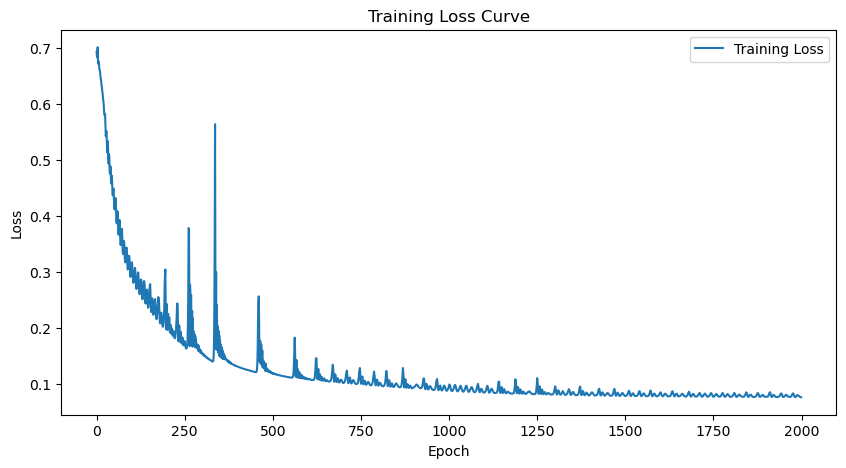

Final Model Accuracy: 84.21%
Final Model F1-score: 0.8558


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.95      0.73      0.83       194
non_infringement       0.77      0.96      0.86       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



/tmp/ipykernel_98462/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 